In [1]:
# install latest diffusers
!pip install diffusers==0.22.1

# install ip-adapter
!pip install git+https://github.com/tencent-ailab/IP-Adapter.git

# download the models
!cd IP-Adapter
!git lfs install
!git clone https://huggingface.co/h94/IP-Adapter
!mv IP-Adapter/models models
!mv IP-Adapter/sdxl_models sdxl_models

# then you can use the notebook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.6 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.31.0
    Uninstalling diffusers-0.31.0:
      Successfully uninstalled diffusers-0.31.0
  Cloning https://github.com/tencent-ailab/IP-Adapter.git to /tmp/pip-req-build-26uqlfdo
  Running command git clone --filter=blob:none --quiet https://github.com/tencent-ailab/IP-Adapter.git /tmp/pip-req-build-26uqlfdo
  Resolved https://github.com/tencent-ailab/IP-Adapter.git to commit 62e4af9d0c1ac7d5f8dd386a0ccf2211346af1a2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ip-adapter: filename=ip_adapter-0.1.0-py3-none-any.whl size=32685 sha256=10903c4995a4a2ebd02775ee98f3ae184165d3b7797d44c14c7185c08dbeb532
  Stored in directory: /tmp/pip-ephem-wheel-cache-83nthe6i/wheels/db/b9/4a/cbddf1447388c3c9e674d4b1eb51f4661cd8ae89b90f34deee
Success

In [3]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image

from ip_adapter import IPAdapter

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "models/image_encoder/"
ip_ckpt = "models/ip-adapter_sd15.bin"
device = "cuda"

In [5]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

## Image Variations

In [72]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


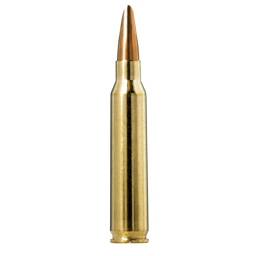

In [73]:
# read image prompt
image = Image.open("/tmp/good_bullet_fixed.jpg")
image.resize((256, 256))

In [74]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

/usr/local/lib/python3.10/dist-packages/ip_adapter/ip_adapter.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.ip_ckpt, map_location="cpu")

  0%|          | 0/50 [00:00<?, ?it/s]

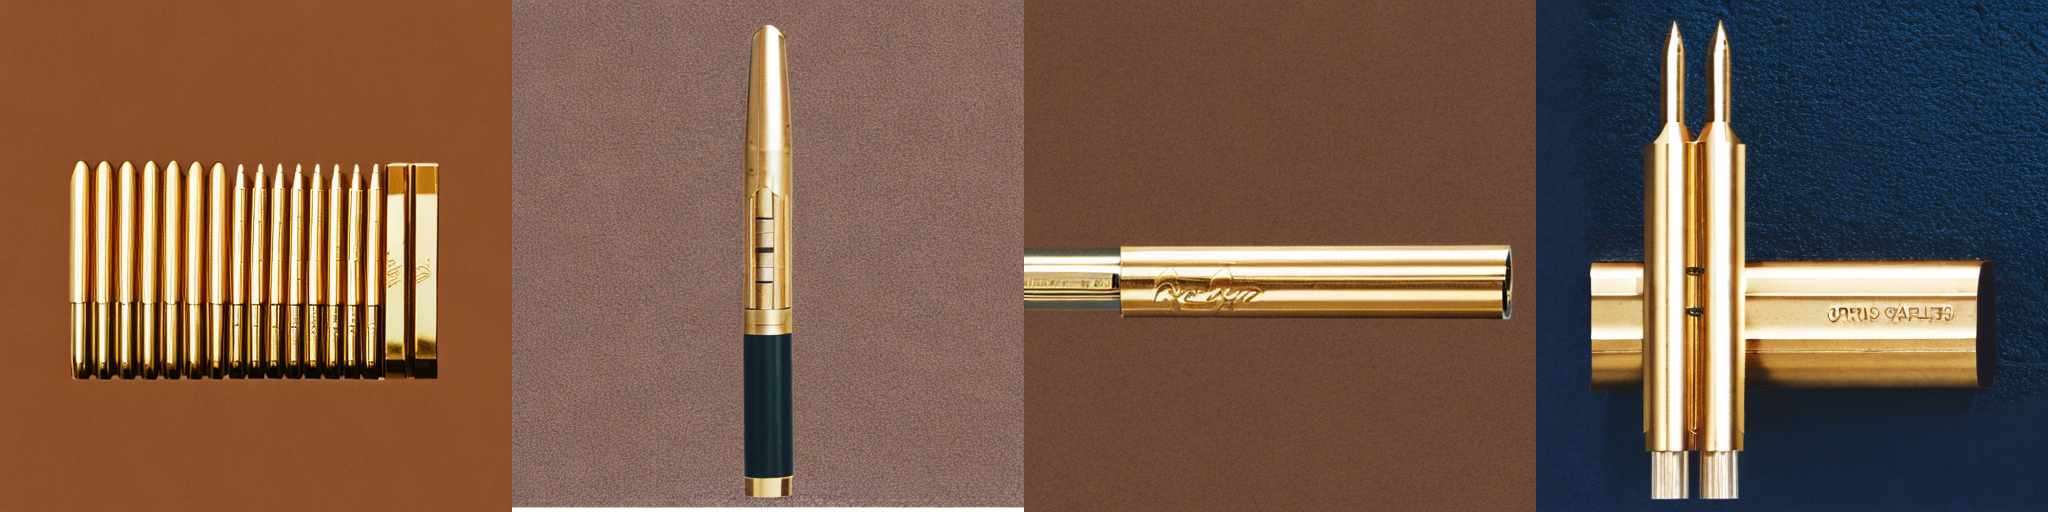

In [75]:
# generate image variations
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid

## Image-to-Image

In [66]:
# load SD Img2Img pipe
del pipe, ip_model
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


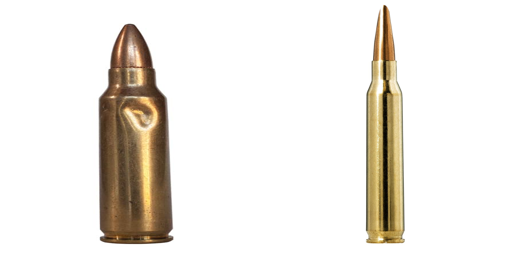

In [63]:
# read image prompt
image = Image.open("/tmp/dented.jpg")
g_image = Image.open("/tmp/good_bullet_fixed.jpg")
image_grid([image.resize((256, 256)), g_image.resize((256, 256))], 1, 2)

In [64]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

In [65]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42, image=g_image, strength=0.6)
grid = image_grid(images, 1, 4)
grid

  0%|          | 0/30 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.12 GiB. GPU 0 has a total capacity of 14.75 GiB of which 2.98 GiB is free. Process 3255 has 11.77 GiB memory in use. Of the allocated memory 8.79 GiB is allocated by PyTorch, and 2.85 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Inpainting

In [56]:
# load SD Inpainting pipe
del pipe, ip_model
torch.cuda.empty_cache()
pipe = StableDiffusionInpaintPipelineLegacy.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


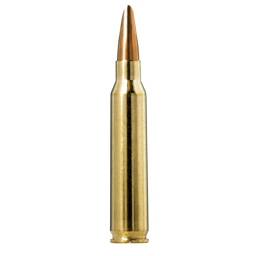

In [49]:
# read image prompt
image = Image.open("/tmp/good_bullet_fixed.jpg")
image.resize((256, 256))

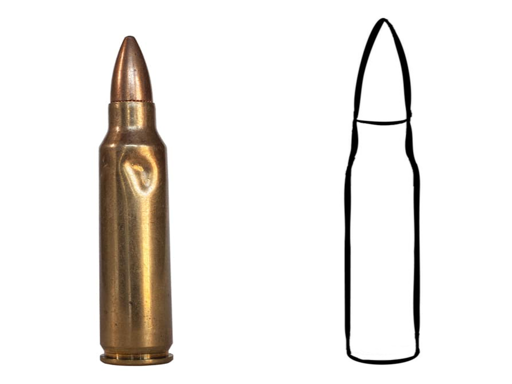

In [48]:
masked_image = Image.open("/tmp/dented.jpg").resize((512, 768))
mask = Image.open("/tmp/bullet_outline.jpg").resize((512, 768))
image_grid([masked_image.resize((256, 384)), mask.resize((256, 384))], 1, 2)

In [43]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

  0%|          | 0/35 [00:00<?, ?it/s]

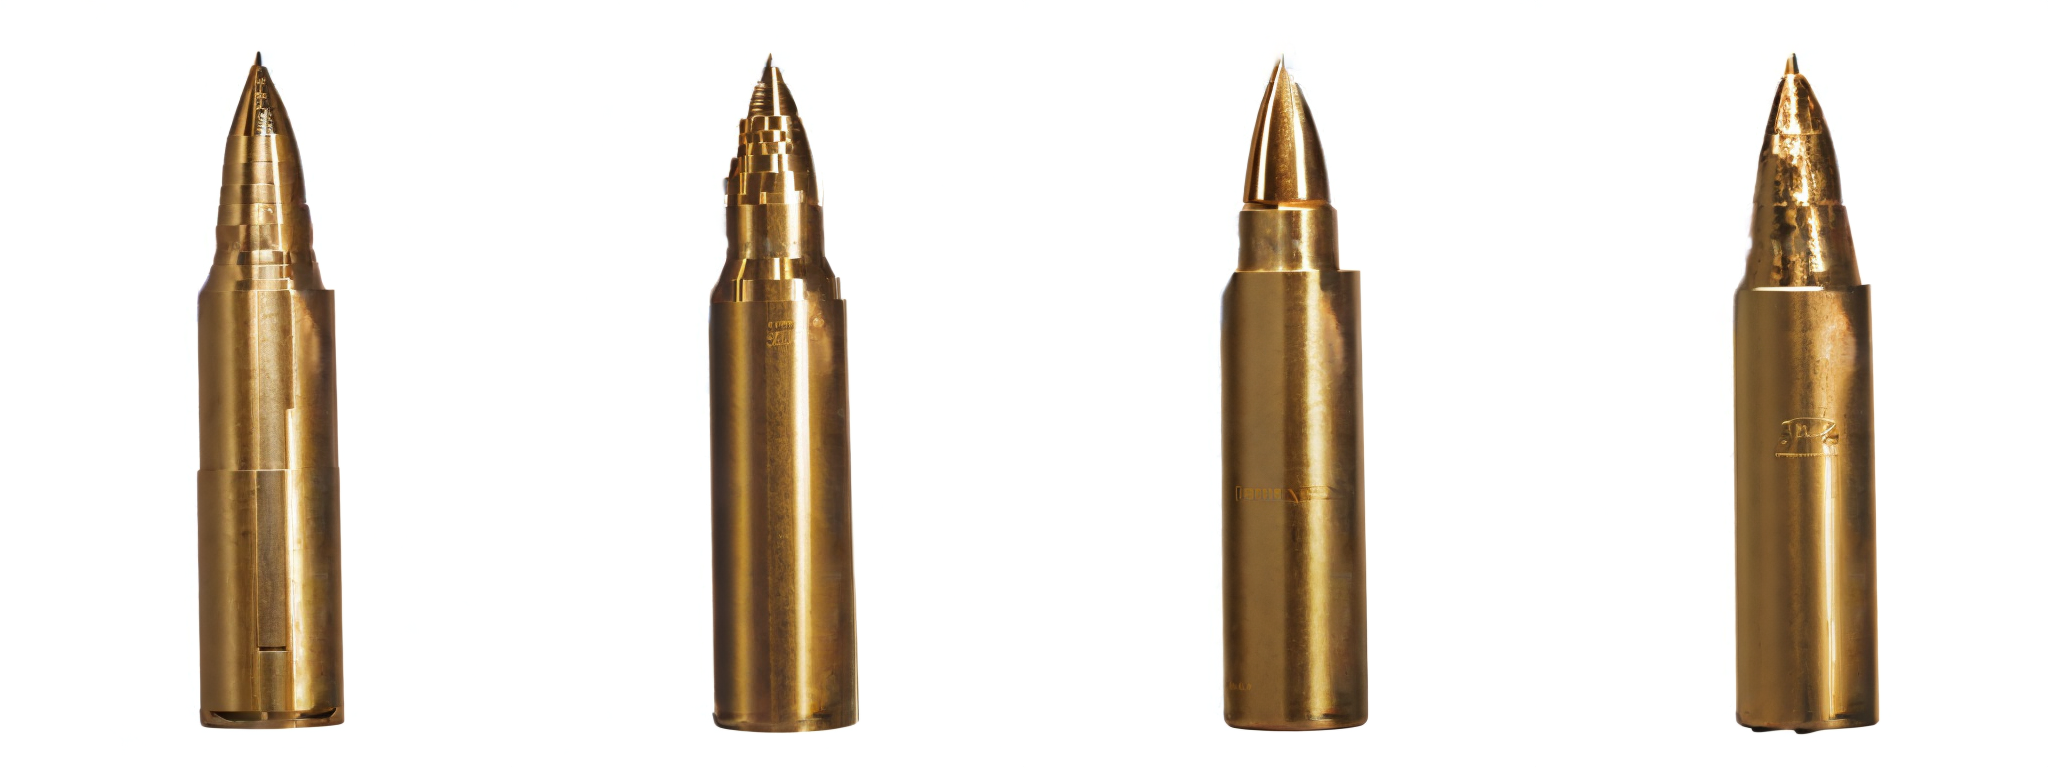

In [50]:
# generate
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50,
                           seed=42, image=masked_image, mask_image=mask, strength=0.7, )
grid = image_grid(images, 1, 4)
grid